# Welcome to the election ballot varifier!
Elections are high-stake. There is plenty of incentive to cheat. With this, I hope to find duplicate ballots.

### Dataset + Data Augmentation
The dataset is only a handful of ballot images, but they will be duplicated, and slightly rotated.

### Cluster
We'll be employing a series of machine learning techniques, particularly focusing on image processing and clustering algorithms.

In [5]:
%pip install matplotlib
%pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


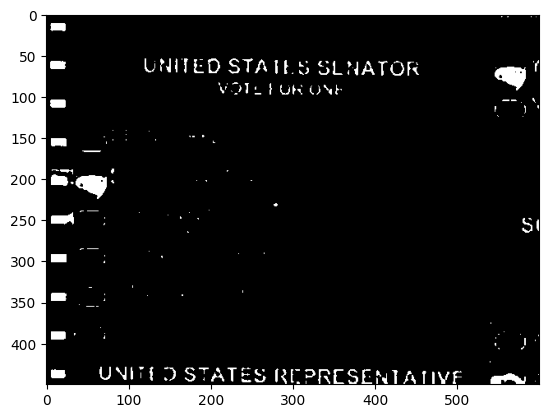

In [92]:
image_width = 600
image_height = 450

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    image = cv2.resize(image, (image_width, image_height))  # Resize images (example size, adjust as needed)
    _, image = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY_INV)  # Thresholding for clarity
    return image

# Example: Loading a single image
image_path = './images/noballot_2.jpg'
ballot_image = load_and_preprocess_image(image_path)

plt.imshow(ballot_image, cmap='gray')
plt.show()

In [7]:
def extract_features(image):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image.flatten()

features = extract_features(ballot_image)
print(features)

[249 246 251 ... 252 253 252]


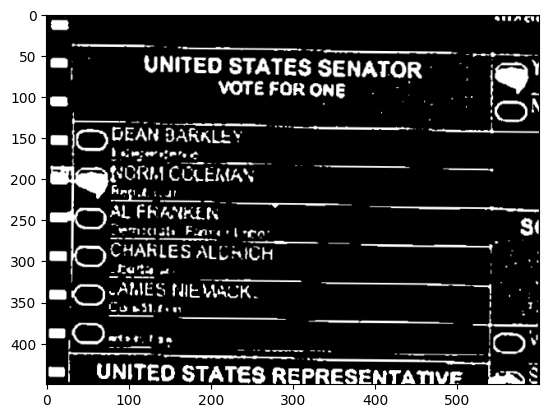

In [8]:
import random

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

rotated_image = rotate_image(ballot_image, random.random() * random.randint(-5, 5))

plt.imshow(rotated_image, cmap='gray')
plt.show()

In [30]:
num_augmented_copies = 5
dir = './images'
augmented_dir = 'augmented'
output_dir = os.path.join(dir, augmented_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def augment_images(image_path, num_copies, label):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    base_name = os.path.basename(image_path).split('.')[0]

    for i in range(num_copies):
        angle = random.uniform(-5, 5)
        new_image = rotate_image(image, angle)
        new_filename = f"{label}_{base_name}_var{i}.jpg"
        cv2.imwrite(os.path.join(output_dir, new_filename), new_image)

for i, filename in enumerate(os.listdir(dir)):
    if i < 2:
        if filename.endswith('.jpg'):
            image_path = os.path.join(dir, filename)
            augment_images(image_path, 1, 'not_duplicate')
    elif filename.endswith('.jpg'):
        image_path = os.path.join(dir, filename)
        augment_images(image_path, num_augmented_copies, 'duplicate')


In [31]:
from sklearn.model_selection import train_test_split
import glob

# Load images and labels
image_paths = glob.glob(f'{output_dir}/*.jpg')
labels = [1 if 'duplicate' in path else 0 for path in image_paths]  # 1 for duplicate, 0 for original

# Split the data
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [32]:
def process_images(file_paths, labels):
    images = []
    for file in file_paths:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))  # Resize to the input size of your model
        img = img / 255.0  # Normalize pixel values
        images.append(img)

    return np.array(images), np.array(labels)

train_images, train_labels = process_images(train_paths, train_labels)
val_images, val_labels = process_images(val_paths, val_labels)


In [33]:
ballot_images = os.listdir(dir)
# print(ballot_images)
all_features = [extract_features(os.path.join(dir, image)) for image in ballot_images]
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(all_features)
# print(all_features)

/Users/jhelmers/Documents/GitHub/Coursera-Supervised-Learning-Final/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jhelmers/Documents/GitHub/Coursera-Supervised-Learning-Final/venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),  # Note the change here
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7308 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 167ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 166ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 173ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 173ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 170ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 208ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0

### Clustering by dot shape

In [93]:
def extract_dot_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (image_width, image_height))
    _, thresh = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) for c in contours if cv2.contourArea(c) > 0]  # Filter out zero-area contours

    if areas:
        mean_area = np.mean(areas)
        std_area = np.std(areas)
        min_area = np.min(areas)
        max_area = np.max(areas)
    else:
        mean_area, std_area, min_area, max_area = 0, 0, 0, 0

    return [mean_area, std_area, min_area, max_area]


def cluster_by_dot_shapes(image_paths, n_clusters=3):
    all_features = []

    for path in image_paths:
        img = cv2.imread(path)
        features = extract_dot_features(img)
        all_features.append(features)

    # Clustering
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(all_features)
    return labels


In [94]:
image_paths = [os.path.join(dir, augmented_dir, filepath) for filepath in os.listdir(output_dir)]
print(image_paths)
dot_cluster_labels = cluster_by_dot_shapes(image_paths, 10)
print(dot_cluster_labels)

['./images/augmented/duplicate_noballot_2_var2.jpg', './images/augmented/duplicate_noballot_3_var2.jpg', './images/augmented/duplicate_noballot_8_var1.jpg', './images/augmented/duplicate_noballot_8_var0.jpg', './images/augmented/duplicate_noballot_3_var3.jpg', './images/augmented/duplicate_noballot_2_var3.jpg', './images/augmented/duplicate_noballot_3_var1.jpg', './images/augmented/duplicate_noballot_2_var1.jpg', './images/augmented/duplicate_noballot_8_var2.jpg', './images/augmented/duplicate_noballot_8_var3.jpg', './images/augmented/duplicate_noballot_2_var0.jpg', './images/augmented/duplicate_noballot_3_var0.jpg', './images/augmented/duplicate_noballot_3_var4.jpg', './images/augmented/duplicate_noballot_2_var4.jpg', './images/augmented/duplicate_noballot_8_var4.jpg', './images/augmented/duplicate_noballot_4_var4.jpg', './images/augmented/duplicate_noballot_5_var4.jpg', './images/augmented/duplicate_noballot_5_var2.jpg', './images/augmented/duplicate_noballot_4_var2.jpg', './images/a

/Users/jhelmers/Documents/GitHub/Coursera-Supervised-Learning-Final/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/jhelmers/Documents/GitHub/Coursera-Supervised-Learning-Final/venv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


index 12 is out of bounds for axis 0 with size 10
index 15 is out of bounds for axis 0 with size 10
index 20 is out of bounds for axis 0 with size 10
index 24 is out of bounds for axis 0 with size 10
index 32 is out of bounds for axis 0 with size 10
index 27 is out of bounds for axis 0 with size 10
index 30 is out of bounds for axis 0 with size 10
index 36 is out of bounds for axis 0 with size 10
index 13 is out of bounds for axis 0 with size 10
index 14 is out of bounds for axis 0 with size 10
index 21 is out of bounds for axis 0 with size 10
index 22 is out of bounds for axis 0 with size 10
index 26 is out of bounds for axis 0 with size 10
index 23 is out of bounds for axis 0 with size 10
index 35 is out of bounds for axis 0 with size 10
index 16 is out of bounds for axis 0 with size 10
index 18 is out of bounds for axis 0 with size 10
index 33 is out of bounds for axis 0 with size 10
index 11 is out of bounds for axis 0 with size 10
index 28 is out of bounds for axis 0 with size 10


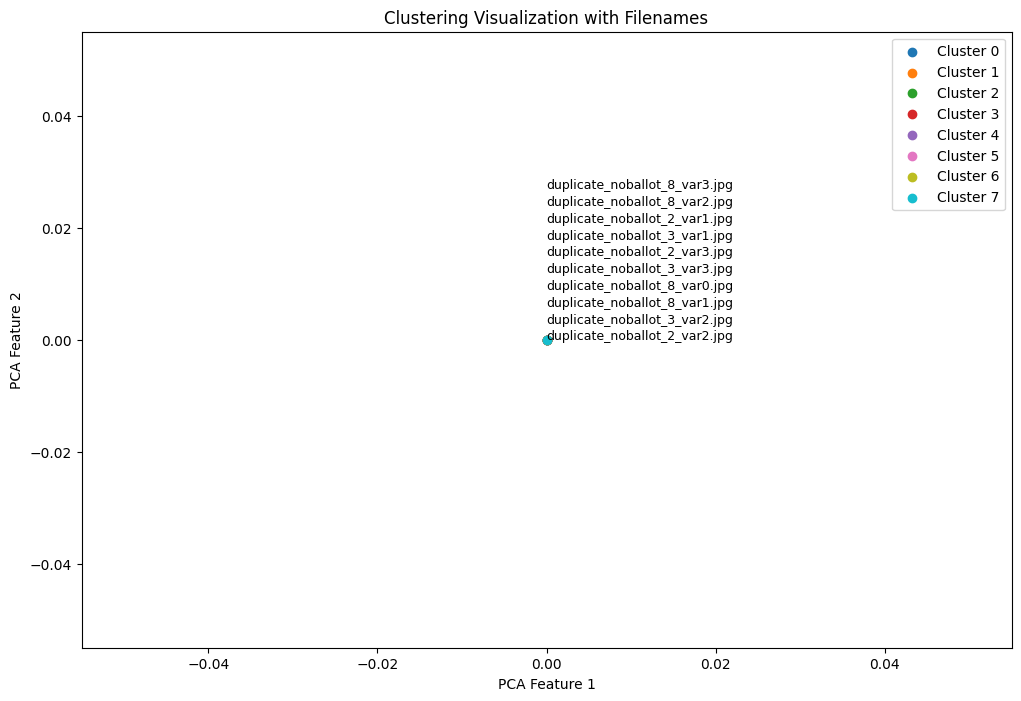

In [101]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features)

# Plotting with filenames
plt.figure(figsize=(12, 8))

for i, label in enumerate(np.unique(dot_cluster_labels)):
    cluster_indices = np.where(dot_cluster_labels == label)[0]
    offset = 0.003  # Adjust this value as needed
    for index in cluster_indices:
        try:
            plt.scatter(reduced_features[index, 0], reduced_features[index, 1], label=f'Cluster {label}' if index == cluster_indices[0] else "")
            plt.text(reduced_features[index, 0], reduced_features[index, 1] + offset * index, os.path.basename(image_paths[index]), fontsize=9)
        except Exception as e:
            print(e)


plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Clustering Visualization with Filenames')
plt.legend()
plt.show()

### Clustering by voting patterns

In [15]:
def extract_voting_pattern(image, vote_positions):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    pattern = []
    for x, y in vote_positions:
        pattern.append(thresh[y, x])  # 255 if the position is marked, else 0
    return pattern

def cluster_by_voting_patterns(image_paths, vote_positions, n_clusters=3):
    all_patterns = []

    for path in image_paths:
        img = cv2.imread(path)
        pattern = extract_voting_pattern(img, vote_positions)
        all_patterns.append(pattern)

    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(all_patterns)
    return labels


In [16]:
for filepath in os.listdir(output_dir):
    print(filepath)

duplicate_noballot_2_var2.jpg
duplicate_noballot_3_var2.jpg
duplicate_noballot_8_var1.jpg
duplicate_noballot_8_var0.jpg
duplicate_noballot_3_var3.jpg
duplicate_noballot_2_var3.jpg
duplicate_noballot_3_var1.jpg
duplicate_noballot_2_var1.jpg
duplicate_noballot_8_var2.jpg
duplicate_noballot_8_var3.jpg
duplicate_noballot_2_var0.jpg
duplicate_noballot_3_var0.jpg
duplicate_noballot_3_var4.jpg
duplicate_noballot_2_var4.jpg
duplicate_noballot_8_var4.jpg
duplicate_noballot_4_var4.jpg
duplicate_noballot_5_var4.jpg
duplicate_noballot_5_var2.jpg
duplicate_noballot_4_var2.jpg
duplicate_noballot_4_var3.jpg
duplicate_noballot_5_var3.jpg
duplicate_noballot_4_var1.jpg
duplicate_noballot_5_var1.jpg
duplicate_noballot_5_var0.jpg
duplicate_noballot_4_var0.jpg
duplicate_noballot_7_var1.jpg
duplicate_noballot_6_var1.jpg
not_duplicate_noballot_1_var0.jpg
not_duplicate_noballot_0_var0.jpg
duplicate_noballot_6_var0.jpg
duplicate_noballot_7_var0.jpg
duplicate_noballot_6_var2.jpg
duplicate_noballot_7_var2.jpg
du